In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rebound
import reboundx
import pandas as pd
from celmech.poincare import Poincare
import scipy.optimize as opt
%matplotlib inline

In [2]:
from celmech.disturbing_function import df_coefficient_Ctilde
from celmech.disturbing_function import evaluate_df_coefficient_dict
from celmech.disturbing_function import laplace_b as b
from scipy.optimize import fsolve

In [3]:
def b1(alpha):
    return b(1.5, 1, 0, alpha)
def b2(alpha):
    return b(1.5, 2, 0, alpha)

In [4]:
def StoG(mass, amp, phi):
    m1, m3 = mass
    A1, A2, A3 = amp
    p1, p2, p3 = phi
    
    e1_x = A1*np.cos(p1) - np.sqrt(m3/m1)*A2*np.cos(p2)
    e2_x = A1*np.cos(p1) - A3*np.cos(p3)
    e3_x = A1*np.cos(p1) + np.sqrt(m1/m3)*A2*np.cos(p2)
    
    e1_y = A1*np.sin(p1) - np.sqrt(m3/m1)*A2*np.sin(p2)
    e2_y = A1*np.sin(p1) - A3*np.sin(p3)
    e3_y = A1*np.sin(p1) + np.sqrt(m1/m3)*A2*np.sin(p2)
    
    e1, e2, e3 = np.sqrt(e1_x**2 + e1_y**2), np.sqrt(e2_x**2 + e2_y**2), np.sqrt(e3_x**2 + e3_y**2)
    pom1, pom2, pom3 = np.arctan2(e1_y,e1_x), np.arctan2(e2_y,e2_x), np.arctan2(e3_y,e3_x)
    
    return (e1, e2, e3), (pom1, pom2, pom3)

In [5]:
def GtoS(alpha, mass, ecc, pomega):
    alpha12, alpha23 = alpha
    alpha13 = alpha12*alpha23
    m1, m3 = mass
    ecc1, ecc2, ecc3 = ecc
    pom1, pom2, pom3 = pomega

    e1_x, e2_x, e3_x = ecc1*np.cos(pom1), ecc2*np.cos(pom2), ecc3*np.cos(pom3)
    e1_y, e2_y, e3_y = ecc1*np.sin(pom1), ecc2*np.sin(pom2), ecc3*np.sin(pom3)
    
    amp1 = 1/(m1+m3) * np.sqrt((m1*e1_y + m3*e3_y)**2 + (m1*e1_x + m3*e3_x)**2)
    amp2 = np.sqrt(m1*m3)/(m1+m3) * np.sqrt((e3_y-e1_y)**2 + (e3_x-e1_x)**2)
    amp3 = 1/(m1+m3) * np.sqrt((m3*(e3_y-e2_y)-m1*(e2_y-e1_y))**2+(m3*(e3_x-e2_x)-m1*(e2_x-e1_x))**2)
    
    phase1 = np.arctan2(m1*e1_y+m3*e3_y, m1*e1_x+m3*e3_x)
    phase2 = np.arctan2(e3_y-e1_y, e3_x-e1_x)
    phase3 = np.arctan2(m3*(e3_y-e2_y)-m1*(e2_y-e1_y), m3*(e3_x-e2_x)-m1*(e2_x-e1_x))
    
    omega2 = (alpha12+alpha13+alpha23)/3 * (m1+m3)/(2*(1-alpha13)**2)
    omega3 = (alpha12+alpha13+alpha23)/3 * (m1/(2*(1-alpha12)**2) + m3/(2*(1-alpha23)**2))
    
    return amp1, amp2, amp3, phase1, phase2, phase3, omega2, omega3

In [6]:
# set A2 to zero
def breathingON1(mass, A3_p):
    m1, m3 = mass
    
    x1 = np.sqrt(m3/m1)
    x2 = 1
    y1 = np.sqrt(m1/m3)
    y2 = 1

    if m1==m3:
        A3_b = A3_p / np.sqrt(2)
        A2_b = A3_b*x2/x1
        theta = np.pi/2
    else:
        def A2(theta):
            return np.fabs(2*A3_p*x2*y2*np.cos(theta) / np.sqrt((x1*y2-x2*y1)**2 + 4*x1*x2*y1*y2*(np.cos(theta))**2))
        def A3(theta):
            return np.fabs(A3_p*(x1*y2-x2*y1) / np.sqrt((x1*y2-x2*y1)**2 + 4*x1*x2*y1*y2*(np.cos(theta))**2))
        def e21_min(theta):
            return -(x1*A2(theta) + x2*A3(theta))**2
        def e32_min(theta):
            return -(y1*A2(theta) + y2*A3(theta))**2
        
        minimizer_kwargs = dict(method="L-BFGS-B", bounds=[(0,2*np.pi)])
        result21 = opt.basinhopping(e21_min, x0=0, minimizer_kwargs=minimizer_kwargs, niter=50)
        result32 = opt.basinhopping(e32_min, x0=0, minimizer_kwargs=minimizer_kwargs, niter=50)
        
        if np.fabs(result21.fun) > np.fabs(result32.fun):
            theta = result21.x
            A2_b, A3_b = A2(theta), A3(theta)
        else:
            theta = result32.x
            A2_b, A3_b = A2(theta), A3(theta)
    
    return A2_b, A3_b, theta

In [7]:
# set A3 to zero
def breathingON2(mass, A2_p):
    m1, m3 = mass
    
    x1 = np.sqrt(m3/m1)
    x2 = 1
    y1 = np.sqrt(m1/m3)
    y2 = 1

    if m1==m3:
        A2_b = A2_p / np.sqrt(2)
        A3_b = A2_b*x1/x2
        theta = np.pi/2
    else:
        def A2(theta):
            return np.fabs(A2_p*(x1*y2-x2*y1) / np.sqrt((x1*y2-x2*y1)**2 + 4*x1*x2*y1*y2*(np.cos(theta))**2))
        def A3(theta):
            return np.fabs(2*A2_p*x1*y1*np.cos(theta) / np.sqrt((x1*y2-x2*y1)**2 + 4*x1*x2*y1*y2*(np.cos(theta))**2))
        def e21_min(theta):
            return -(x1*A2(theta) + x2*A3(theta))**2
        def e32_min(theta):
            return -(y1*A2(theta) + y2*A3(theta))**2
        
        minimizer_kwargs = dict(method="L-BFGS-B", bounds=[(0,2*np.pi)])
        result21 = opt.basinhopping(e21_min, x0=0, minimizer_kwargs=minimizer_kwargs, niter=50)
        result32 = opt.basinhopping(e32_min, x0=0, minimizer_kwargs=minimizer_kwargs, niter=50)
        
        if np.fabs(result21.fun) > np.fabs(result32.fun):
            theta = result21.x
            A2_b, A3_b = A2(theta), A3(theta)
        else:
            theta = result32.x
            A2_b, A3_b = A2(theta), A3(theta)
    
    return A2_b, A3_b, theta

In [11]:
def sim(alpha, mass, ecc, pom, scale):
    alpha12, alpha23 = alpha
    P1, P2, P3 = alpha12**(3/2), 1, 1/alpha23**(3/2)
    m1, m3 = mass
    ecc1, ecc2, ecc3 = ecc
    pomega1, pomega2, pomega3 = pom
    
    # start simulation
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')

    # add star, planet 1, planet 2
    sim.add(m=1.)
    sim.add(m=m1, P=P1, e=ecc1, pomega=pomega1)
    sim.add(P=P2, e=ecc2, pomega=pomega2)
    sim.add(m=m3, P=P3, e=ecc3, pomega=pomega3)
    ps = sim.particles
    ps[1].r = ps[1].a*(ps[1].m/3/ps[0].m)**(1/3)
    ps[2].r = ps[2].a*(ps[2].m/3/ps[0].m)**(1/3)

    sim.move_to_com()
    sim.integrator = "whfast"
    sim.dt = sim.particles[1].P/20
    sim.collision = "direct"
    
#     pvars = Poincare.from_Simulation(sim)
#     alpha12 = pvars.particles[1].a/pvars.particles[2].a
#     alpha23 = pvars.particles[2].a/pvars.particles[3].a
#     alpha13 = pvars.particles[1].a/pvars.particles[3].a
#     print(f"alpha = {alpha12, alpha23, alpha13}")
    
    Nout=400
    ecc1, ecc2, ecc3, e21, e32, eminus, e13 = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
    times = np.linspace(0,scale,Nout)
    
    for i, time in enumerate(times):
        try:
            sim.integrate(time)
            info_1 = sim.particles[1].calculate_orbit(primary=sim.particles[0])
            info_2 = sim.particles[2].calculate_orbit(primary=sim.particles[0])
            info_3 = sim.particles[3].calculate_orbit(primary=sim.particles[0])
            p1, p2, p3, e1, e2, e3 = info_1.pomega, info_2.pomega, info_3.pomega, info_1.e, info_2.e, info_3.e
            e1_x, e1_y = e1*np.cos(p1), e1*np.sin(p1)
            e2_x, e2_y = e2*np.cos(p2), e2*np.sin(p2)
            e3_x, e3_y = e3*np.cos(p3), e3*np.sin(p3)  
            eminus_x, eminus_y = (m3*(e3_x-e2_x)-m1*(e2_x-e1_x))/(m1+m3), (m3*(e3_y-e2_y)-m1*(e2_y-e1_y))/(m1+m3)
            e13[i] = np.sqrt((e3_x-e1_x)**2+(e3_y-e1_y)**2)
            
            ecc1[i] = e1
            ecc2[i] = e2
            ecc3[i] = e3
            
            eminus[i] = np.sqrt(eminus_x**2 + eminus_y**2)
            
            e21[i] = np.sqrt((e2_x-e1_x)**2 + (e2_y-e1_y)**2)
            e32[i] = np.sqrt((e3_x-e2_x)**2 + (e3_y-e2_y)**2)
                       
        except rebound.Collision:
            break
    
    fig, axarr = plt.subplots(nrows=5, figsize=(12,14))
    axarr[0].plot(times, eminus, 'k.')
    axarr[0].set_ylabel(r"$e_{-}$")
    
    axarr[1].plot(times, ecc2, 'k.')
    axarr[1].set_ylabel(r"$e_{2}$")
    
    axarr[2].plot(times, ecc3, 'k.')
    axarr[2].set_ylabel(r"$e_{3}$")
    
    axarr[3].plot(times, e21, 'k.')
    axarr[3].set_ylabel(r"$e_{21}$")
    
    axarr[4].plot(times, e32, 'k.')
    axarr[4].set_ylabel(r"$e_{32}$")

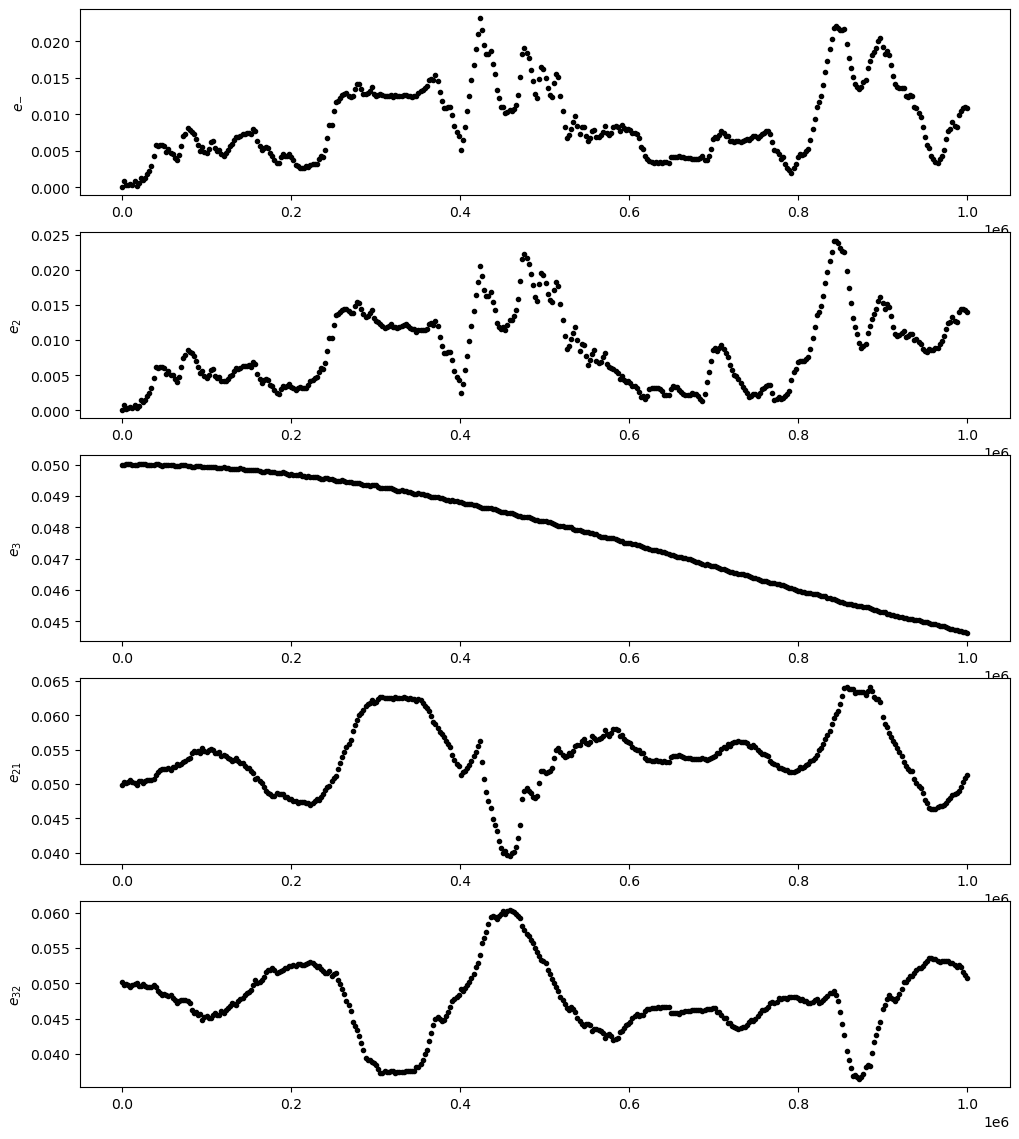

In [23]:
alpha = 0.93,0.93
mass = 3e-8,3e-8
ecc = 0.05, 1e-4, 0.05
pomega = 0, 0, np.pi
amp1, amp2, amp3, phase1, phase2, phase3, omega2, omega3 = GtoS(alpha, mass, ecc, pomega)
sim(alpha, mass, ecc, pomega, 1e6)

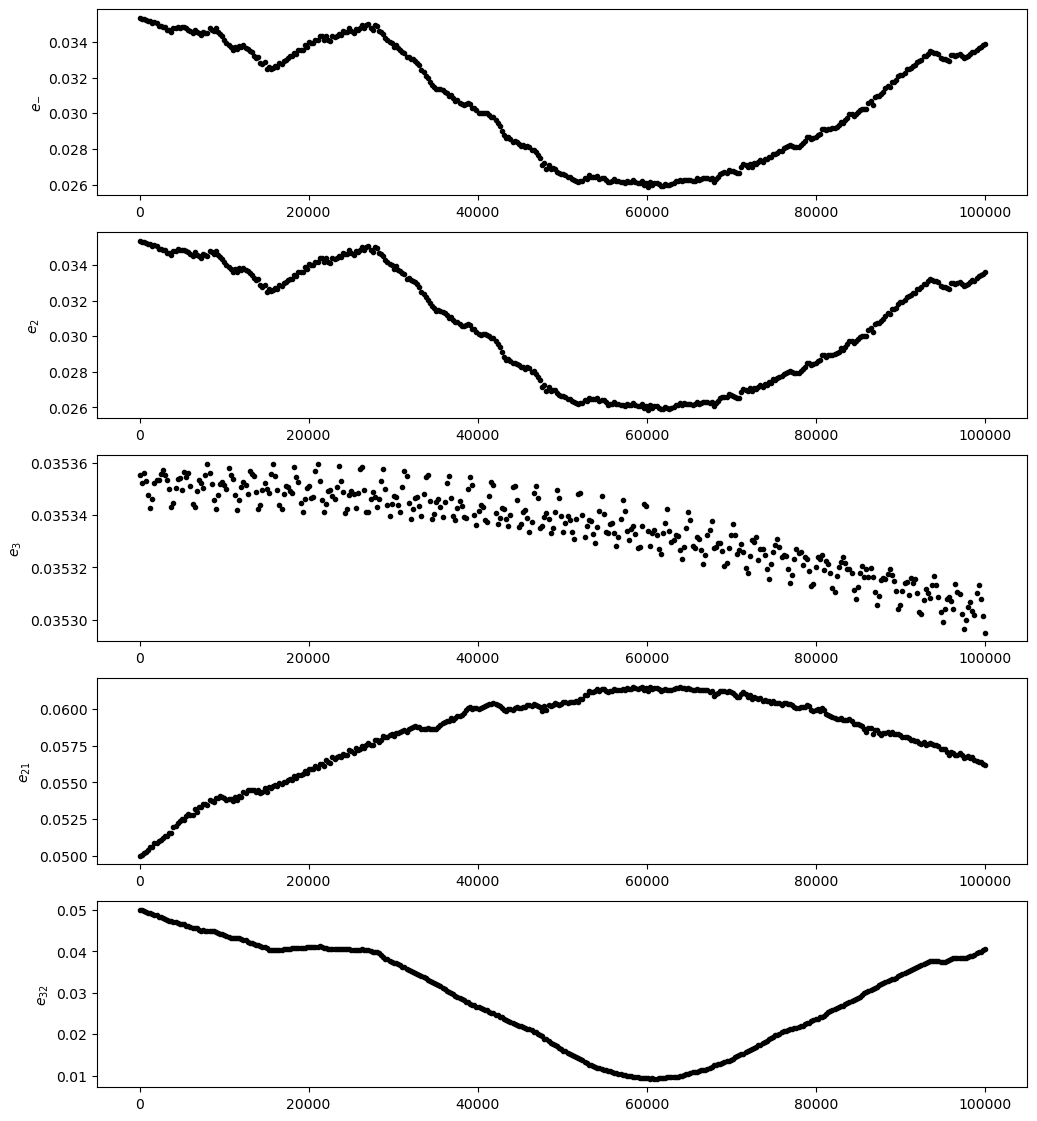

In [24]:
A2, A3, theta = breathingON2(mass,amp2)
# print(theta)
ecc, pomega = StoG(mass, (amp1, A2, A3), (phase1, phase2, phase2+theta))
sim(alpha, mass, ecc, pomega, 1e5)

In [ ]:
# first-order resonance chart

<div>
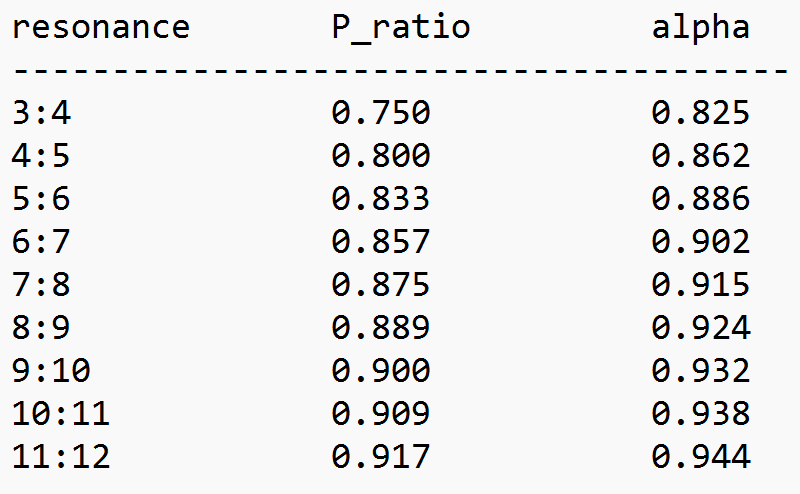
</div>